In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/page_phishing/scikitlearn/default/1/stacking_page_model.pkl
/kaggle/input/phishing/PhiUSIIL_Phishing_URL_Dataset.csv
/kaggle/input/url_phishing/scikitlearn/default/1/stacking_url_model.pkl


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
import re
import joblib

In [3]:
df = pd.read_csv("/kaggle/input/phishing/PhiUSIIL_Phishing_URL_Dataset.csv")
df.head

<bound method NDFrame.head of            FILENAME                                                URL  \
0        521848.txt                   https://www.southbankmosaics.com   
1         31372.txt                           https://www.uni-mainz.de   
2        597387.txt                     https://www.voicefmradio.co.uk   
3        554095.txt                        https://www.sfnmjournal.com   
4        151578.txt                 https://www.rewildingargentina.org   
...             ...                                                ...   
235790   660997.txt                     https://www.skincareliving.com   
235791    77185.txt                      https://www.winchester.gov.uk   
235792   622132.txt                    https://www.nononsensedesign.be   
235793  7503962.txt  https://patient-cell-40f5.updatedlogmylogin.wo...   
235794   384822.txt                 https://www.alternativefinland.com   

        URLLength                                           Domain  \
0          

In [25]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Shape: (235795, 56)

Columns: ['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'label']

Data Types:
 FILENAME                       object

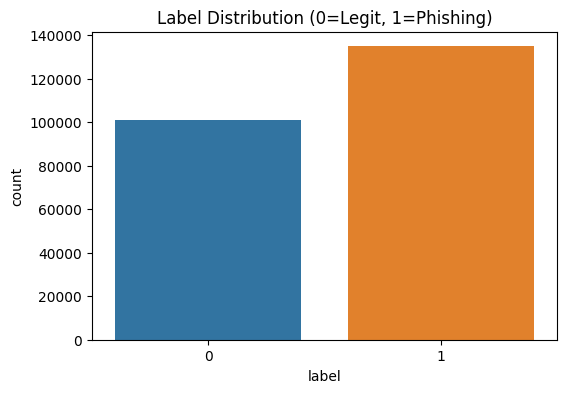

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df)
plt.title("Label Distribution (0=Legit, 1=Phishing)")
plt.show()

In [27]:
print(df.describe().T.head(10))

                         count       mean        std        min        25%  \
URLLength             235795.0  34.573095  41.314153  13.000000  23.000000   
DomainLength          235795.0  21.470396   9.150793   4.000000  16.000000   
IsDomainIP            235795.0   0.002706   0.051946   0.000000   0.000000   
URLSimilarityIndex    235795.0  78.430778  28.976055   0.155574  57.024793   
CharContinuationRate  235795.0   0.845508   0.216632   0.000000   0.680000   
TLDLegitimateProb     235795.0   0.260423   0.251628   0.000000   0.005977   
URLCharProb           235795.0   0.055747   0.010587   0.001083   0.050747   
TLDLength             235795.0   2.764456   0.599739   2.000000   2.000000   
NoOfSubDomain         235795.0   1.164758   0.600969   0.000000   1.000000   
HasObfuscation        235795.0   0.002057   0.045306   0.000000   0.000000   

                             50%         75%          max  
URLLength              27.000000   34.000000  6097.000000  
DomainLength         

In [88]:
url_features = [
    "URLLength","DomainLength","IsDomainIP","TLD","TLDLength",
    "NoOfSubDomain","HasObfuscation","NoOfObfuscatedChar","ObfuscationRatio",
    "NoOfLettersInURL","LetterRatioInURL","NoOfDegitsInURL","DegitRatioInURL",
    "NoOfEqualsInURL","NoOfQMarkInURL","NoOfAmpersandInURL",
    "NoOfOtherSpecialCharsInURL","SpacialCharRatioInURL","IsHTTPS"
]
content_features = [
    "LineOfCode","LargestLineLength","HasTitle","Title",
    "DomainTitleMatchScore","URLTitleMatchScore","HasFavicon","Robots","IsResponsive",
    "NoOfURLRedirect","NoOfSelfRedirect","HasDescription","NoOfPopup","NoOfiFrame",
    "HasExternalFormSubmit","HasSocialNet","HasSubmitButton","HasHiddenFields",
    "HasPasswordField","Bank","Pay","Crypto","HasCopyrightInfo",
    "NoOfImage","NoOfCSS","NoOfJS","NoOfSelfRef","NoOfEmptyRef","NoOfExternalRef"
]
target = "label"

In [89]:
df_url = df[url_features + [target]]
df_content = df[content_features + [target]]

In [31]:
df_url.head()

,URLLength,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,label
0,31,24,0,com,3,1,0,0,0.0,18,0.581,0,0.0,0,0,0,1,0.032,1,1
1,23,16,0,de,2,1,0,0,0.0,9,0.391,0,0.0,0,0,0,2,0.087,1,1
2,29,22,0,uk,2,2,0,0,0.0,15,0.517,0,0.0,0,0,0,2,0.069,1,1
3,26,19,0,com,3,1,0,0,0.0,13,0.500,0,0.0,0,0,0,1,0.038,1,1
4,33,26,0,org,3,1,0,0,0.0,20,0.606,0,0.0,0,0,0,1,0.030,1,1


In [32]:
 df_content.head()

,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,558,9381,1,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...,0.000000,0.000000,0,1,1,0,...,0,0,1,34,20,28,119,0,124,1
1,618,9381,1,johannes gutenberg-universitÃ¤t mainz,55.555556,55.555556,1,1,0,0,...,0,0,1,50,9,8,39,0,217,1
2,467,682,1,voice fm southampton,46.666667,46.666667,0,1,1,0,...,0,0,1,10,2,7,42,2,5,1
3,6356,26824,1,home page: seminars in fetal and neonatal medi...,0.000000,0.000000,0,1,1,0,...,1,1,1,3,27,15,22,1,31,1
4,6089,28404,1,fundaciÃ³n rewilding argentina,100.000000,100.000000,0,1,1,1,...,1,0,1,244,15,34,72,1,85,1


In [33]:
print("URL-based dataset shape:", df_url.shape)
print("Content-based dataset shape:", df_content.shape)

URL-based dataset shape: (235795, 20)
Content-based dataset shape: (235795, 30)


# **URL MODEL**

In [34]:
X = df_url.drop("label", axis=1)
y = df_url["label"]

In [35]:
categorical_features = ["TLD"]
numeric_features = [col for col in X.columns if col not in categorical_features]

In [36]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # missing
    ("scaler", StandardScaler())                     # normalize
])

In [37]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
X_train

,URLLength,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS
104874,24,17,0,com,3,1,0,0,0.0,11,0.458,0,0.0,0,0,0,1,0.042,1
176003,22,15,0,jp,2,2,0,0,0.0,8,0.364,0,0.0,0,0,0,2,0.091,1
137445,26,19,0,site,4,1,0,0,0.0,14,0.538,0,0.0,0,0,0,1,0.038,0
38100,39,32,0,org,3,2,0,0,0.0,25,0.641,0,0.0,0,0,0,2,0.051,1
65088,30,23,0,com,3,1,0,0,0.0,16,0.533,0,0.0,0,0,0,2,0.067,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160997,32,25,0,au,2,3,0,0,0.0,17,0.531,0,0.0,0,0,0,3,0.094,1
155379,24,18,0,com,3,1,0,0,0.0,12,0.500,0,0.0,0,0,0,1,0.042,0
174379,54,46,0,co,2,2,0,0,0.0,43,0.796,0,0.0,0,0,0,3,0.056,1
920,27,20,0,com,3,1,0,0,0.0,14,0.519,0,0.0,0,0,0,1,0.037,1


In [41]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (188636, 19)
Test shape: (47159, 19)


In [42]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=42, class_weight="balanced"),
    "CatBoost": CatBoostClassifier(iterations=300, depth=10, learning_rate=0.1, random_seed=42, verbose=0)
}

results = []

In [46]:
from sklearn.ensemble import StackingClassifier

stacking_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", StackingClassifier(
        estimators=[
            ("lgbm", LGBMClassifier(n_estimators=200, random_state=42)),
            ("xgb", XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric="logloss")),
            ("cat", CatBoostClassifier(iterations=200, random_seed=42, verbose=0))
        ],
        final_estimator=LogisticRegression(max_iter=2000, class_weight="balanced"),
        passthrough=True,   # keep original features + model preds
        cv=5
    ))
])

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)

print("Stacking Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("Stacking Ensemble F1:", f1_score(y_test, y_pred))


[LightGBM] [Info] Number of positive: 107880, number of negative: 80756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 188636, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571895 -> initscore=0.289587
[LightGBM] [Info] Start training from score 0.289587
[LightGBM] [Info] Number of positive: 86304, number of negative: 64604
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 150908, number of used features: 188
[LightGBM] [Inf

In [48]:
import joblib

joblib.dump(stacking_clf, "stacking_url_model.pkl")
print("Model saved as stacking_url_model.pkl")

Model saved as stacking_url_model.pkl


In [10]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 2.2 MB/s eta 0:00:00a 0:00:01


In [11]:
import tldextract

In [4]:
suspicious_keywords = {
    "login": ["login", "signin", "account"],
    "secure": ["secure", "verify", "update"],
    "bank": ["bank", "paypal", "chase", "wellsfargo"],
    "payment": ["payment", "billing", "invoice"],
    "support": ["support", "helpdesk"]
}

def add_keyword_features(url, features_dict):
    domain_path = url.lower()
    total_suspicious = 0
    for key, keywords in suspicious_keywords.items():
        features_dict[f"has_{key}"] = int(any(k in domain_path for k in keywords))
        if features_dict[f"has_{key}"]:
            total_suspicious += 1
    features_dict["num_suspicious_keywords"] = total_suspicious
    return features_dict



In [5]:

def extract_url_features(url, known_tlds=None):
    if known_tlds is None:
        known_tlds = {"com", "org", "net", "gov", "co.uk", "info", "io"}

    original_url = url
    
    if not url.startswith(("http://", "https://")):
        url = "http://" + url

    ext = tldextract.extract(url)
    domain = ext.domain
    subdomain = ext.subdomain
    tld = ext.suffix if ext.suffix in known_tlds else "unknown"

    # URLLength: The length of the URL string including the protocol
    url_length = len(original_url)

    # DomainLength: Length of the full host, including subdomain and TLD
    domain_full = f"{subdomain}.{domain}.{tld}" if subdomain else f"{domain}.{tld}"
    domain_length = len(domain_full)

    # IsDomainIP
    is_domain_ip = 1 if re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$", domain) else 0

    # TLDLength
    tld_length = len(tld)

    # NoOfSubDomain: The number of parts in the subdomain
    no_of_subdomain = len([s for s in subdomain.split('.') if s]) if subdomain else 0

    # Obfuscation: The provided ground truth for this URL is 0, 0, 0.0
    has_obfuscation = 0
    no_of_obfuscated = 0
    obfuscation_ratio = 0.0

    # NoOfLettersInURL & LetterRatioInURL: The ground truth value of 18 letters
    # suggests counting only the 'southbankmosaics' part of the URL.
    letters = sum(c.isalpha() for c in domain)
    letter_ratio = letters / url_length if url_length > 0 else 0

    # NoOfDegitsInURL & DegitRatioInURL
    digits = sum(c.isdigit() for c in original_url)
    digit_ratio = digits / url_length if url_length > 0 else 0

    # Special Characters: The ground truth counts for this URL are 1 and 0.032.
    # This implies that only the single '/' is counted.
    no_of_equals = original_url.count("=")
    no_of_qmark = original_url.count("?")
    no_of_amp = original_url.count("&")
    no_of_other_special = original_url.count("/")
    spacial_char_ratio = no_of_other_special / url_length if url_length > 0 else 0

    # IsHTTPS
    is_https = 1 if original_url.lower().startswith("https://") else 0

    features = {
        "URLLength": url_length,
        "DomainLength": domain_length,
        "IsDomainIP": is_domain_ip,
        "TLD": tld,
        "TLDLength": tld_length,
        "NoOfSubDomain": no_of_subdomain,
        "HasObfuscation": has_obfuscation,
        "NoOfObfuscatedChar": no_of_obfuscated,
        "ObfuscationRatio": obfuscation_ratio,
        "NoOfLettersInURL": letters,
        "LetterRatioInURL": letter_ratio,
        "NoOfDegitsInURL": digits,
        "DegitRatioInURL": digit_ratio,
        "NoOfEqualsInURL": no_of_equals,
        "NoOfQMarkInURL": no_of_qmark,
        "NoOfAmpersandInURL": no_of_amp,
        "NoOfOtherSpecialCharsInURL": no_of_other_special,
        "SpacialCharRatioInURL": spacial_char_ratio,
        "IsHTTPS": is_https
    }

    return pd.DataFrame([features])

In [4]:
# Assuming your training DataFrame is called df_train
KNOWN_TLDS = X_train['TLD'].unique().tolist()
print("Known TLDs from training dataset:", KNOWN_TLDS)

NameError: name 'X_train' is not defined

In [6]:
KNOWN_TLDS = ['com', 'jp', 'site', 'org', 'gd', 'my', 'no', 'me', 'id', 'edu', 'io', 'app', 'de', 'in', 'nz', 'au', 'info', 'cl', 'nl', 'ru', 'net', 'eu', 'pl', 'uk', 'co', 'ca', 'kr', 'ch', 'kim', 'cloud', 'ge', 'cards', 'cf', 'club', 'link', 'fr', 'one', 'us', 'se', 'ro', 'xyz', 'am', 'art', 'hr', 'fun', 'it', 'plus', 'gov', 'ga', 'fm', 'vn', 'gal', 'top', 'sg', 'dev', 'digital', 'za', 'tv', 'es', 'fi', 'ar', 'at', 'tr', 'cz', 'dk', 'be', 'watch', 'video', 'az', 'fit', 'biz', 'pk', 'cn', 'to', 'br', 'uz', 'cc', 'ir', 'coop', 'li', 'pe', '238', 'ie', 'bg', 'business', 'ws', 'hu', 'mil', 'cyou', 'shop', 'uno', 'zw', 'host', '146', 'gr', 'ua', 'sc', 'ht', 'pro', 'pw', 'mobi', 'sh', 'pt', 'kz', 'land', 'hk', 'ma', 've', 'th', 'rs', 'ee', 'ml', 'ae', 'il', 'bd', 'online', '232', 'pet', 'ug', 'is', 'nyc', 'nf', 'ng', 'al', 'page', 'tokyo', 'network', '67', 'gy', 'space', 'bid', 'bio', 'world', 'gp', 'do', 'by', 'email', 'website', 'asia', 'work', 'tw', 'si', 'pg', 'lk', 'tech', 'hn', 'lv', 'guru', 'travel', 'mx', 'ec', 'store', 'mn', 'tk', 'services', 'st', 'na', 'uy', 'name', 'ph', '181', '178', 'place', 'im', 'date', 'gq', 'mm', 'live', 'lc', 'center', '41', 'life', 'expert', 'gi', 'vip', 'icu', 'mv', 'nu', 'su', 'gle', 'np', 'cfd', '86', 'media', 'jo', 'lu', 'zone', 'sa', 're', 'lt', 'news', '69', 'school', 'ly', 'ke', 'church', 'la', 'xn--p1ai', 'lol', '24', 'sport', 'fyi', 'institute', 'lighting', 'navy', 'gg', 'mq', 'cy', 'swiss', 'ai', 'exchange', 'sk', '136', 'studio', 'mom', 'bw', 'sbs', 'tn', '128', 'cat', 'bo', 'bz', 'pics', 'mz', 'win', 'tz', 'market', 'int', 'dz', 'je', 'pm', 'company', 'law', 'ink', 'mk', 'museum', 'party', 'ngo', 'ba', 'eg', '154', 'bank', '103', 'science', 'jm', 'vg', 'technology', 'iq', 'qa', 'so', 'stream', 'cool', 'tl', 'monster', 'bf', 'academy', 'cx', 'fashion', 'games', 'buzz', 'tc', 'bar', '87', 'xn--p1acf', 'ltd', 'money', 'best', '21', 'ss', 'computer', 'eus', 'fj', '42', 'cash', '26', 'quest', 'berlin', 'py', 'mg', 'cr', 'bet', 'lb', 'bt', 'bh', 'vote', 'land:443', 'fund', 'global', 'scot', 'ax', 'systems', 'fk', 'goog', '234', '20', 'bb', 'casa', 'kg', 'archi', 'com:2096', '120', 'tt', 'health', 'solutions', 'xn--6frz82g', 'wales', 'mt', 'tm', 'love', 'ad', 'gl', 'cam', 'af', 'guide', 'click', '252', 'farm', 'wiki', 'lr', 'ac', '116', 'green', 'group', 'ls', 'mp', '78', 'cu', 'vu', 'red', 'finance', 'today', '94', 'gt', 'cm', 'blog', 'vc', 'tips', 'skin', 'bm', 'care', '150', 'college', 'ps', 'auto', 'gf', 'ovh', 'photo', 'tools', 'marketing', 'kh', 'sv', 'mu', 'ci', '80', 'aero', 'rest', 'supply', 'tg', '197', 'md', 'social', 'hair', 'run', '130', 'build', 'aw', 'ao', '223', 'hamburg', 'homes', 'pink', 'cars', '133:8080', 'design', 'nagoya', 'om', 'cd', 'basketball', 'trade', 'ms', 'gh', '171', 'garden', 'mba', 'paris', 'report', '189', 'google', 'investments', 'africa', '101', 'events', 'moe', 'soy', 'yt', 'rw', '28', 'coach', 'domains', 'ist', 'zm', 'team', 'pn', 'pl:443', 'london', 'review', 'fo', 'krd', 'wine', 'kn', 'tj', 'as', '15', 'holdings', '95', '12', 'autos', '158', 'beauty', '11', 'photos', '148', 'gives', '140', 'bn', '30', 'pa', '13', 'ky', 'ooo', 'mc', 'sd', '68:8080', 'mw', '123', 'rocks', 'rentals', '211', 'lgbt', '126', 'amsterdam', 'kw', 'sn', 'chat', 'band', 'agency', 'istanbul', 'house', 'camera', 'markets', 'gdn', 'nc', '231', 'boutique', '242', 'bi', 'yachts', 'com:443', '38', 'dj', 'camp', '108', 'cymru', '200', 'download', 'vegas', 'works', 'photography', 'foundation', 'press', 'dog', '188:10003', 'hosting', 'dm', 'game', 'toys', 'city', 'ne', 'bike', 'com:9595', 'menu', 'bs', 'sb', '106', '230', 'car', 'reviews', 'wf', 'koeln', 'golf', 'wtf', 'sm', 'tf', 'sy', 'limo', 'cafe', 'vet', '240:8087', 'gifts', '117', 'tours', 'tel', 'cv', 'ni', 'gs', 'taxi', '185', '210', '220', 'education', '237', 'bj', 'capital', 'diamonds', 'vi', 'tattoo', '250', '199', '155', 'dental', 'sx', 'careers', 'support', '235', 'eco', 'ag', 'loan', '100', 'radio', 'coffee', 'delivery', 'xn--mk1bu44c', 'show', 'ninja', 'rugby', '149', '214', '47', '173', 'fitness', 'sr', 'gallery', 'gay', 'help', 'moscow', 'pf', 'pub', 'ski', '206', '254:30332', 'jobs', '198', 'rip', 'earth', '134', 'holiday', '166', 'corsica', 'limited', 'salon', 'gold', 'audio', '51', 'xn--90ais', '126:8080', 'mma', 'tirol', '187', 'shoes', '111', 'nr', 'promo', 'energy', '52', '182', 'youtube', 'sexy', 'mo', 'sz', '184', 'engineering', 'aq', 'parts', '196', 'lat', 'express', '233', 'ruhr', '121', 'builders', '71', 'recipes', 'mr', '43', 'family', '161', 'madrid', 'movie', 'community', 'fr:443', 'repair', '151', '160', 'study', '110', 'consulting', 'direct', '163', 'furniture', 'cc:8443', '107', 'associates', 'beer', '167', '33', 'clothing', 'bayern', '46', 'schule', 'ck', 'tatar', '221', '227', 'town', 'kiwi', 'training', 'nrw', 'vlaanderen', 'theater', '203', 'et', '63', 'gmbh', '211:8383', 'black', '243', 'lundbeck', '177', 'kred', 'ki', 'legal', 'com:4000', 'yoga', '145', '125', 'xn--c1avg', '80:8085', '84', 'barcelona', 'sharp', '216', 'tax', '225', 'software', 'kitchen', 'healthcare', 'neustar', 'ntt', 'mortgage', 'taipei', 'faith', 'management', 'international', 'condos', 'cleaning', 'maison']

In [7]:
def compute_heuristic_risk(url, known_tlds, base_prob):
    """
    Combines model probability with heuristic scoring:
    - Adds risk for unknown TLD
    - Adds risk for suspicious keywords
    """
    ext = tldextract.extract(url)
    tld = ext.suffix if ext.suffix in known_tlds else "unknown"
    
    risk = base_prob
    if tld == "unknown":
        risk += 0.6  

    suspicious_keywords = {
        "login": ["login", "signin", "account"],
        "secure": ["secure", "verify", "update"],
        "bank": ["bank", "paypal", "chase", "wellsfargo"],
        "payment": ["payment", "billing", "invoice"],
        "support": ["support", "helpdesk"]
    }
    
    url_lower = url.lower()
    keyword_count = sum(1 for kws in suspicious_keywords.values() 
                        for k in kws if k in url_lower)
    
    risk += 0.3 * keyword_count
    risk = min(risk, 1.0)  
    
    return risk


In [12]:
url = "https://www.5movierulz.villas/"
X_new = extract_url_features(url, KNOWN_TLDS)
model = joblib.load("/kaggle/input/url_phishing/scikitlearn/default/1/stacking_url_model.pkl")
base_prob = model.predict_proba(X_new)[:,1][0]
final_prob = compute_heuristic_risk(url, KNOWN_TLDS, base_prob)
risk_score_100 = round(final_prob*100, 2)

prediction = 1 if final_prob >= 0.5 else 0

print("Prediction (0=legit, 1=phishing):", prediction)
print("Phishing probability:", final_prob)
print("Phishing Risk Score (0-100):", risk_score_100)

Prediction (0=legit, 1=phishing): 1
Phishing probability: 1.0
Phishing Risk Score (0-100): 100.0


In [88]:
print(X_new.T)

                                   0
URLLength                         24
DomainLength                      21
IsDomainIP                         0
TLD                          unknown
TLDLength                          7
NoOfSubDomain                      1
HasObfuscation                     0
NoOfObfuscatedChar                 0
ObfuscationRatio                 0.0
NoOfLettersInURL                   8
LetterRatioInURL            0.333333
NoOfDegitsInURL                    0
DegitRatioInURL                  0.0
NoOfEqualsInURL                    0
NoOfQMarkInURL                     0
NoOfAmpersandInURL                 0
NoOfOtherSpecialCharsInURL         2
SpacialCharRatioInURL       0.083333
IsHTTPS                            1
